In [1]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow import keras
from keras.models import load_model
from scipy.spatial import distance_matrix
import os
import cv2
import numpy as np
import SimpleITK as sitk
import glob
import os
from scipy.ndimage import distance_transform_cdt
import pickle
from matplotlib import pyplot as plt
#import matplotlib.image as mpimg
import imutils
%matplotlib inline
import pandas as pd
from math import sqrt
import copy

import math

In [48]:
# Function to determine local coordinates in a tile that has been classified as to having containing Neurons
def local_coordinates(file):
    x_coordinates = [] #x-coordinate
    y_coordinates = [] #y-coordinate
    z_coordinates = [] #y-coordinate
    coordinates = [] #x,y-coordinate put together
    #print(file)
    img = cv2.imread(file,0)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #plt.imshow(img,cmap = "gray")
    #plt.show()

    # global thresholding to create binarized image
    ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    # Otsu's thresholding
    ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #plt.imshow(th2,cmap = "gray")
    #plt.show()

    #Gaussian blurring to smoothen the image
    #blur_image = cv2.GaussianBlur(th2,(5,5),0)
    bilat_image = cv2.bilateralFilter(th2,9,75,75)
    median_filtered_image = cv2.medianBlur(bilat_image,5)
    #plt.imshow(blur_image,cmap = "gray")
    #plt.show()

    # calculating the centre of the objects found in the image
    
    # Convert image into a np array
    npimage = np.array(median_filtered_image)
    
    if npimage.any():
        indsx,indsy = np.where(npimage>0)
        xmean,ymean = [indsy.mean(),indsx.mean()]
        print(xmean,ymean)
        Cx,Cy = int(xmean), int(ymean)
        cv2.circle(img, (Cx, Cy), 1, (255, 0, 0), 1)
        
        ##
        #plt.imshow(img,cmap = "gray")
        #plt.show()
    else:
        xmean=0
        ymean =0
    # show the image
    plt.imshow(img,cmap = "gray")
    plt.show()
    
    return xmean,ymean

In [56]:
# Function to determine local coordinates in a tile that has been classified as to having containing Neurons
def blob_local_coordinates(file):
    x_coordinates = [] #x-coordinate
    y_coordinates = [] #y-coordinate
    z_coordinates = [] #y-coordinate
    coordinates = [] #x,y-coordinate put together
    #print(file)
    img = cv2.imread(file)
    # Convert the image into gray scale
    #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.imread(file,0)
    #plt.imshow(img_gray,cmap = "gray")
    #plt.show()

    # global thresholding to create binarized image
    ret1,th1 = cv2.threshold(img_gray,127,255,cv2.THRESH_BINARY)
    # Adding filter of Otsu's thresholding to binarized image
    ret2,th2 = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #plt.imshow(th2,cmap = "gray")
    #plt.show()

    #Gaussian blurring to smoothen the thresholded image to remove salt and pepper noise and improve accuracy
    bilat_image = cv2.bilateralFilter(th2,9,75,75)
    median_filtered_image = cv2.medianBlur(bilat_image,5)
    #plt.imshow(blur_image,cmap = "gray")
    #plt.show()
    
    npimage = np.array(median_filtered_image)
    xlocal = 0
    ylocal = 0
    
    # calculating the centre of the objects found in the image

    if npimage.any():
        #print(npimage)
        
        # find contours in the thresholded image
        cnts = cv2.findContours(median_filtered_image, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        #print("cnts",cnts)
        # loop over the contours
        for c in cnts:
            #print("c",c)
            #print("Sum of c:",np.sum(c))
            #print("mean of c:",np.mean(c,dtype=np.float64)) 
            if (np.sum(c)<6000):
                # compute the center of the contour
                M = cv2.moments(c)
                #print(M)
                area = cv2.contourArea(c)

                if area >130:
                    print("area:",area)
                    indsx,indsy = np.where(npimage>0)
                    xmean,ymean = [indsy.mean(),indsx.mean()]
                    xmean,ymean = int(xmean), int(ymean)
                    print("xmean,ymean:",xmean,ymean)
                    cv2.circle(img, (xmean, ymean), 1, (0, 0, 255), 1)
                    # show the image
                    #plt.imshow(img)
                    #plt.show()
                    
                    cX = int(M["m10"] / (M["m00"]+ 1e-5))
                    cY = int(M["m01"] / (M["m00"]+ 1e-5))
                    print("cX,cY:",cX,cY)
                    xlocal = cX
                    ylocal = cY
                    # draw the contour and center of the shape on the image
                    cv2.drawContours(img, [c], -1, (0, 255, 0), 1)
                    cv2.circle(img, (cX, cY), 1, (255, 0, 0), 1)
                    #bounding rectangle
                    x,y,w,h = cv2.boundingRect(c)
                    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
                    print("x,y:",x,y)
                    # show the image
                    plt.imshow(img)
                    plt.show()
    else:
        xlocal = 0
        ylocal = 0
        
    return xlocal,ylocal

In [4]:
# Function for Creating LandmarkcAscii Files
def writeLandmarkCoords(filename, landmarkList):
  with open(filename, 'w') as file:
     file.write("# Avizo 3D ASCII 2.0 \n")
     file.write("define Markers ")
     file.write("{}".format(len(landmarkList)))
     file.write("\n")
     file.write("Parameters {\n")
     file.write("    NumSets 1,\n")
     file.write("    ContentType \"LandmarkSet\"\n")
     file.write("}\n")

     file.write("Markers { float[3] Coordinates } @1\n")

     file.write("# Data section follows\n")
     file.write("@1\n")
     for landmark in landmarkList:
         file.write("{}".format(landmark[0]))
         file.write(" ")
         file.write("{}".format(landmark[1]))
         file.write(" ")
         file.write("{}".format(landmark[2]))
         file.write("\n")

In [5]:
def read_landmarks(filename,only_2d=True):
    manual_landmark_list = []
    lines = []
    with open(filename, 'r') as csb:
        lines = csb.readlines()
    number = 0

    # for each manual landmark
    for line in lines:
        #print line
        if line.startswith("@1"):
            number = 1
            continue
        if number == 1 and line.isspace() == False:
            #print line.split()
            pt = list(map(float,line.split()))
            #pt = [pt[0]*self.axis_directions[0],pt[1]*self.axis_directions[1],pt[2]*self.axis_directions[2]]
            manual_landmark_list.append([pt[0],pt[1]])

    return manual_landmark_list

In [6]:
def write_landmarks(landmarks,filename):

    with open(filename, 'w') as file:
        file.write("# Avizo 3D ASCII 2.0 \n")
        file.write("define Markers ")
        file.write("{}".format(len(landmarks)))
        file.write("\n")
        file.write("Parameters {\n")
        file.write("    NumSets 1,\n")
        file.write("    ContentType \"LandmarkSet\"\n")
        file.write("}\n")

        file.write("Markers { float[3] Coordinates } @1\n")

        file.write("# Data section follows\n")
        file.write("@1\n")

        if len(landmarks)!=0:
            for landmark in landmarks:
                ##print(landmark[0][0])
                file.write("{}".format(landmark[0]))
                file.write(" ")
                file.write("{}".format(landmark[1]))
                file.write(" ")
                if len(landmark) > 2:
                    file.write("{}".format(landmark[2]))
                else:
                    file.write("{}".format(0))
                file.write("\n")


In [7]:
def centeroidpython(data):
    x, y,z = zip(*data)
    l = len(x)
    return sum(x) / l, sum(y) / l,sum(z)/l

In [52]:
def merge_nearby(lst_):
    keys = list(range(0,len(lst_)))
    dict_data = dict(zip(keys,lst_))
    whole_list = []
    for i in range(0,len(dict_data)):
        single_list = []

        for j in range(i,len(dict_data)):
            distance_ = math.sqrt((dict_data[i][0]-dict_data[j][0])**2+(dict_data[i][1]-dict_data[j][1])**2)
            if  distance_<30:
                #print(distance_)
                single_list.extend([j])
            #print(math.sqrt((dict_data[i][0]-dict_data[j][0])**2+(dict_data[i][1]-dict_data[j][1])**2))
        whole_list.append(single_list)
        #print('#####')
        
    ##make a copy of the dict_list
    all_list = copy.deepcopy(whole_list)
    
    ## make a list of common coordinates <20
    final_list = []
    while len(all_list)>0:
        old_set = all_list[0]

        common_ = [0]
        for i in range(1,len(all_list)):
            new_set = all_list[i]
            if len(set(old_set)&set(new_set)) != 0:

                common_.extend([i])
                old_set = list(set(old_set+new_set))

        final_list.append(old_set)

        for j in reversed(common_):
            all_list.pop(j)
            
    #####make a final list of all the landmarks
    list_final = []
    for i_ in range(0,len(final_list)):
        centroid_list =[]
        for j_ in final_list[i_]:
            centroid_list.append(dict_data[j_])
        #print(centroid_list)
        if len(centroid_list) >1:
            array_list = np.array(centroid_list)
            #print(array_list)
            take_away = list(tuple(i_j) for i_j in array_list)
            #print(take_away)
            X_ = list(centeroidpython(take_away))
            #print(X_)
            list_final.extend([X_])
        else:
            list_final.extend(centroid_list)
    return list_final

# Loading the trained model

In [9]:
model_path = '//ibs9010/current_data/Data_Keshav/image/Classification_model/NeuronClassifierModels/BinaryClassifier_automatic_trial23_20epoch_2layers.h5'
model = keras.models.load_model(model_path)

In [10]:
#MG48 single tile
#Inference_Path = "//ibs9010/current_data/Data_Keshav/Cropped_Images/MG48_bs/S{}/".format(x)
#MG48 Double tile
#Path1 = "//ibs9010/current_data/Data_Keshav/Cropped_Images/DTinference/DT_MG48_bs/"
#MG49 Double tile
#Path1 = "//ibs9010/current_data/Data_Keshav/Cropped_Images/DTinference/DT_MG49_bs/"
#MG45 Double tile
#Path1 = "//ibs9010/current_data/Data_Keshav/Cropped_Images/DTinference/DT_MG45_bs/"
#MG23 90 tile
Path1 = "//ibs9010/current_data/Data_Keshav/Cropped_Images/90tile/MG23_bs/"
#Path1 = '//ibs9010/current_data/Data_Keshav/Cropped_Images/90tile/MG48_bs/'
#MG39 Double tile
#Path1 = '//ibs9010/current_data/Data_Keshav/Cropped_Images/90tile/MG39_bs/'

In [11]:
#Location to save Automatic LM files
#LM_path = '//ibs9010/current_data/Data_Keshav/image/Classification_model/landmarks/MG39_bs/'
LM_path = '//ibs9010/current_data/Data_Keshav/image/Classification_model/landmarks/MG23_bs/'
# Location of Manual MG48 Landmark files
#manual_LM_path = '//ibs9010/current_data/Data_Keshav/image/Classification_model/manual_landmark_files/MG48/'
# Manual MG49 Landmark files
#manual_LM_path = '//ibs9010/current_data/Data_Keshav/image/Classification_model/manual_landmark_files/MG49/'
#manual_LM_path = '//ibs9010/current_data/Data_Keshav/image/Classification_model/manual_landmark_files/MG45/'
manual_LM_path = '//ibs9010/current_data/Data_Keshav/image/Classification_model/manual_landmark_files/MG23/'

# Running Inference

1
//ibs9010/current_data/Data_Keshav/Cropped_Images/90tile/MG23_bs/S1/
Number of test images: 4683
neuron_image_counter: 22 bkgd_image_counter: 4661
area: 157.0
xmean,ymean: 24 26


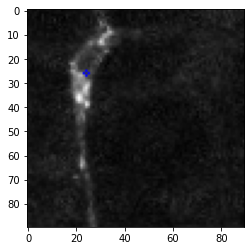

cX,cY: 21 32


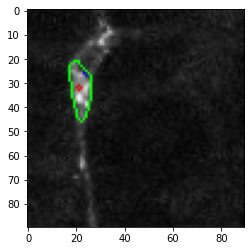

area: 251.0
xmean,ymean: 36 46


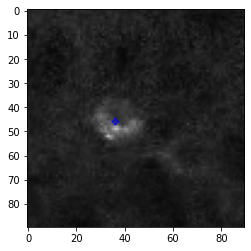

cX,cY: 36 46


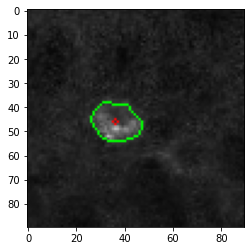

area: 403.0
xmean,ymean: 37 47


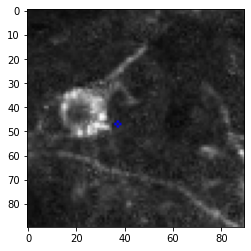

cX,cY: 24 40


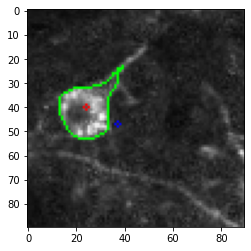

area: 553.5
xmean,ymean: 36 42


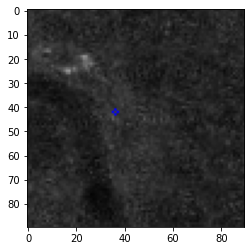

cX,cY: 11 76


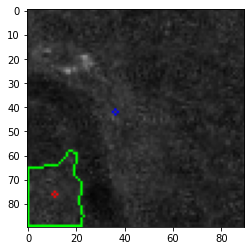

area: 220.5
xmean,ymean: 36 42


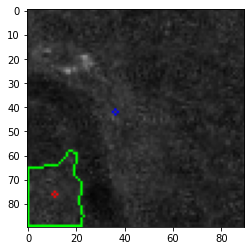

cX,cY: 81 9


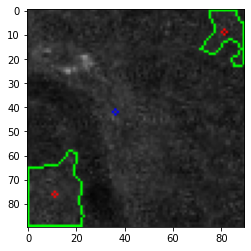

area: 293.5
xmean,ymean: 8 24


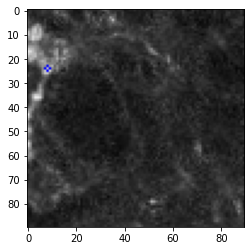

cX,cY: 8 16


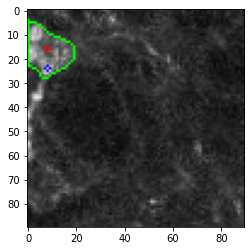

area: 151.5
xmean,ymean: 30 35


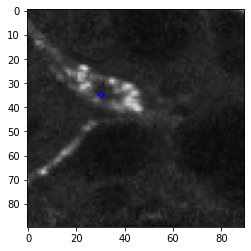

cX,cY: 40 35


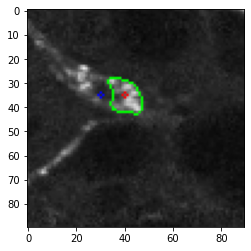

area: 135.5
xmean,ymean: 20 43


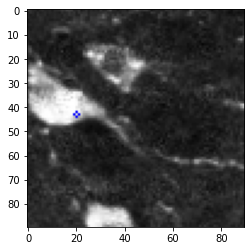

cX,cY: 32 85


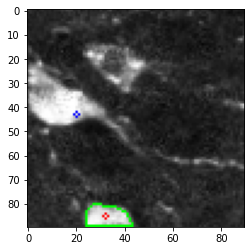

area: 472.5
xmean,ymean: 20 43


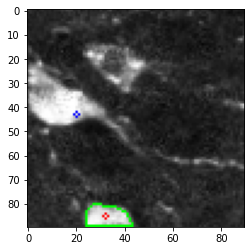

cX,cY: 11 37


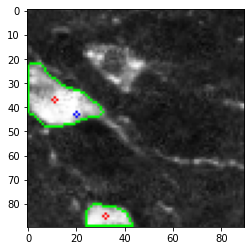

area: 325.0
xmean,ymean: 19 20


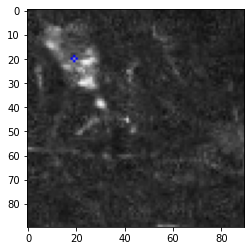

cX,cY: 18 19


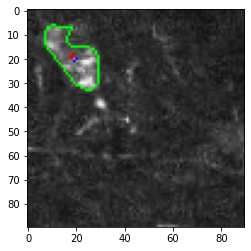

area: 151.0
xmean,ymean: 37 46


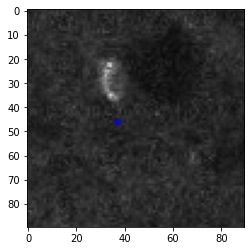

cX,cY: 82 79


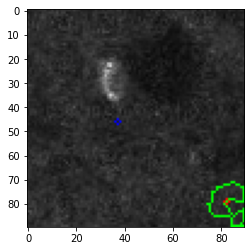

area: 455.5
xmean,ymean: 37 46


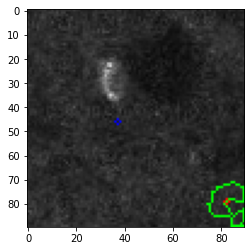

cX,cY: 77 12


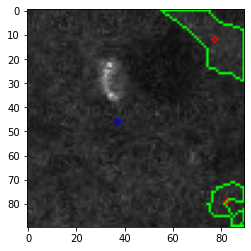

area: 247.5
xmean,ymean: 25 18


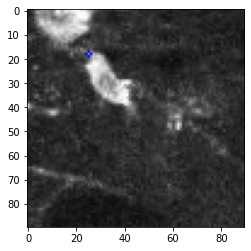

cX,cY: 33 29


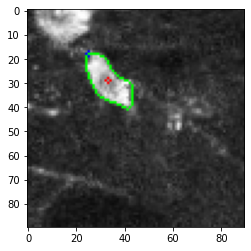

area: 256.0
xmean,ymean: 25 18


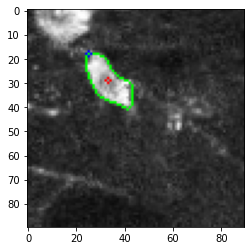

cX,cY: 14 5


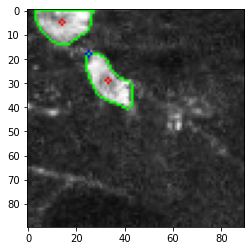

area: 1044.0
xmean,ymean: 37 26


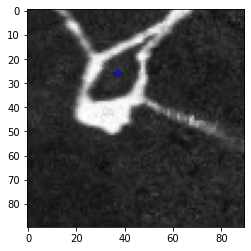

cX,cY: 37 27


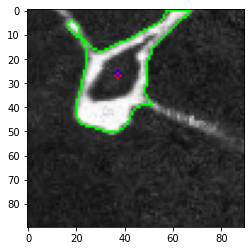

area: 415.5
xmean,ymean: 43 37


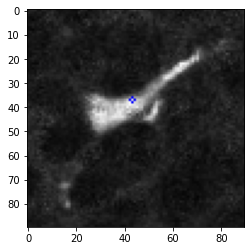

cX,cY: 43 37


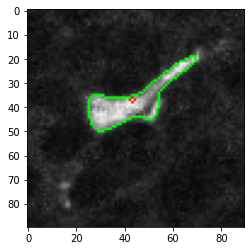

area: 247.5
xmean,ymean: 60 51


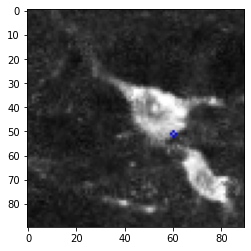

cX,cY: 73 69


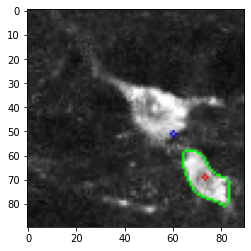

area: 457.5
xmean,ymean: 60 51


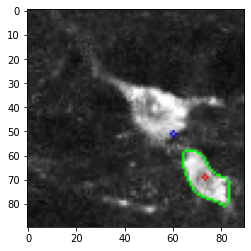

cX,cY: 53 41


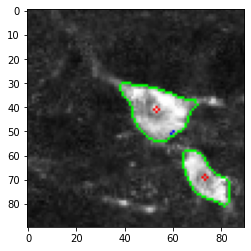

area: 379.5
xmean,ymean: 19 36


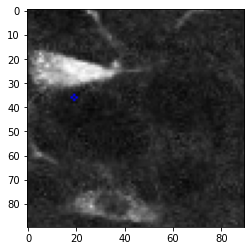

cX,cY: 15 24


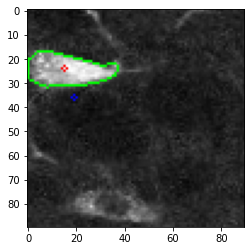

area: 233.0
xmean,ymean: 38 40


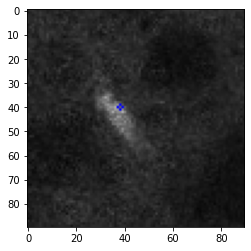

cX,cY: 76 4


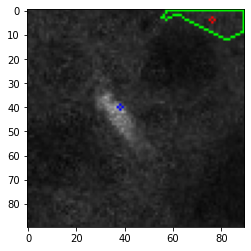

before combine 22
combine 21
TP,FN,FP: 13 17 10
TP_per,FN_per,FP_per: 43.333333333333336 56.666666666666664 33.33333333333333
   slice_number  manual_landmark_count  TP  FN  FP     TP%age     FN%age  \
0             1                     30  13  17  10  43.333333  56.666667   

      FP%age  
0  33.333333  


In [57]:
output = list()

for x in range(1,2):
    print(x)
    global_list = []
    coordinates = []
    templist =[]
    newcoordinatelist = []
    FP = 0
    confusion_mat = 0
    #Exclusions due to lack of images or of landmarks or both.
    #if x in [35,38,80,81,91]:# MG48
    #    continue
    #if x in [68,72,90]:# MG49
    #    continue
    #if x in [40]:# MG39
    #    continue
    if x in [79]:# MG23
        continue
    
    ######################*******CLASSIFICATION######################*******
    #img_size = 70 # fix the size of the image
    img_size = 90 # fix the size of the image
    #MG48 single tile
    #Inference_Path = "//ibs9010/current_data/Data_Keshav/Cropped_Images/MG48_bs/S{}/".format(x)
    #MG48 Double tile
    #Inference_Path = Path1+"S{}/".format(x)
    #MG49 Double tile
    #Inference_Path = Path1+"S{}/".format(x)
    #MG45 Double tile
    #Inference_Path = Path1+"S{}/".format(x)
    #MG23 Double tile
    #Inference_Path = Path1+"S{}/".format(x)
    #100tile
    Inference_Path = Path1+'S{}/'.format(x)
    print(Inference_Path)
    
    Testing_image = []# list of testing images
    image_name = []# list of image names

    for img in os.listdir(Inference_Path): #gives the images from the path
        img_array = cv2.imread(os.path.join(Inference_Path,img),cv2.IMREAD_GRAYSCALE) # read every image in gray scale from the given path
        Testing_image.append(img_array)
        image_name.append(img)

    print("Number of test images:",len(Testing_image))
    
    #Running Inference
    try:
        Test_image = np.array(Testing_image).reshape(-1,img_size,img_size,1)
    except ValueError:
        print(" ValueError")
        continue    
    
    #make an array of every element of list from Testing_image and then reshape them
    Test_image = Test_image/255.0
    scores = model.predict_classes(Test_image)

    # Results
    neuron_image_counter = bkgd_image_counter = 0
    for i in range(len(Test_image)):
        #print("Image:",image_name[i],"with score:",scores[i]) 
        if scores[i]==0:
            bkgd_image_counter +=1
        if scores[i]==1:
            neuron_image_counter += 1

    print("neuron_image_counter:",neuron_image_counter,"bkgd_image_counter:",bkgd_image_counter)
    
    ## Saving classified tiles into respective folders

    #MG48
    #dest_path = '//ibs9010/current_data/Data_Keshav/image/Classification_model/Inference/BinaryClasses/singleneurontiles/MG48_bs/S{}/'.format(x)
    #MG49
    #dest_path = '//ibs9010/current_data/Data_Keshav/image/Classification_model/Inference/BinaryClasses/singleneurontiles/MG49_bs/S{}/'.format(x)
    #MG45
    #dest_path = '//ibs9010/current_data/Data_Keshav/image/Classification_model/Inference/BinaryClasses/singleneurontiles/MG45_bs/S{}/'.format(x)
    #MG23
    dest_path = '//ibs9010/current_data/Data_Keshav/image/Classification_model/Inference/BinaryClasses/singleneurontiles/MG23_bs/S{}/'.format(x)
    #MG39
    #dest_path = '//ibs9010/current_data/Data_Keshav/image/Classification_model/Inference/BinaryClasses/singleneurontiles/MG39_bs/S{}/'.format(x)
    
    if not os.path.exists(dest_path):
       print("path doesn't exist. trying to make the folder.")
       os.makedirs(dest_path)
    
    # Delete any exiting images before saving
    os.chdir(dest_path)
    files=glob.glob('*.tif')
    for filename in files:
        os.remove(filename)

    single_image_list  = [] # contains list of filenames of single neurons
    for k in range(1,len(Test_image)):
        if scores[k]==1:
            single_image_list.append(image_name[k])

    for i in range(len(Test_image)):
        if scores[i]==1:
            cv2.imwrite(os.path.join(dest_path,image_name[i]), Test_image[i]*255)
            #pass
  
    # Generating pickle file For Single neurons
    #MG48
    #with open('//ibs9010/current_data/Data_Keshav/image/Classification_model/PickleFiles/10sep_MG48bs_c_S{:03d}.pkl'.format(x), 'wb') as f:
    #    pickle.dump(single_image_list, f) 
    #MG45
    #with open('//ibs9010/current_data/Data_Keshav/image/Classification_model/PickleFiles/8sep_MG45bs_c_S{:03d}.pkl'.format(x), 'wb') as f:
    #    pickle.dump(single_image_list, f)
    #MG23
    with open('//ibs9010/current_data/Data_Keshav/image/Classification_model/PickleFiles/10sep_MG23bs_c_S{:03d}.pkl'.format(x), 'wb') as f:
        pickle.dump(single_image_list, f)
    #MG39
    #with open('//ibs9010/current_data/Data_Keshav/image/Classification_model/PickleFiles/10sep_MG39bs_c_S{:03d}.pkl'.format(x), 'wb') as f:
    #    pickle.dump(single_image_list, f) 
    ######################*******END of CLASSIFICATION######################*******
    #output = list() 
    #for x in range(51,53):

    #dest_path = '//ibs9010/current_data/Data_Keshav/image/Classification_model/Inference/BinaryClasses/MG48_bs/S{}/'.format(x)
    
    #ENTER loaded_data from cropped data pickle file
    #with open('//ibs9010/current_data/Data_Keshav/image/Classification_model/PickleFiles/10sep_MG39bs_c_S{:03d}.pkl'.format(x),'rb') as f:
    #    loaded_obj = pickle.load(f) # Classification data
    with open('//ibs9010/current_data/Data_Keshav/image/Classification_model/PickleFiles/10sep_MG23bs_c_S{:03d}.pkl'.format(x),'rb') as f:
        loaded_obj = pickle.load(f) # Classification data
    
    #ENTER loaded_data from cropped data pickle file
    #with open('//ibs9010/current_data/Data_Keshav/image/Classification_model/global_xy_MG48_3day_bs_S51_multiiteration_piamasked.pkl'.format(x),'rb') as g:
    #    loaded_data = pickle.load(g) #cropped_data
    
    #single tiling
    #with open('//ibs9010/current_data/Data_Keshav/image/Classification_model/PickleFiles/global_xy_MG48_bs_S{}_singletile_piamasked.pkl'.format(x),'rb') as g:
    #    loaded_data = pickle.load(g)#cropped_data #global_xy_MG48_bs_S{}_singletile_piamasked
    
    # Double tiling MG48
    #with open('//ibs9010/current_data/Data_Keshav/image/Classification_model/PickleFiles/global_xy_MG48_bs_S{}_doubletile_piamasked.pkl'.format(x),'rb') as g:
    #    loaded_data = pickle.load(g)#cropped_data #global_xy_MG49_bs_S87_doubletile_piamasked
    
    # Triple tiling MG48
    #with open('//ibs9010/current_data/Data_Keshav/image/Classification_model/PickleFiles/global_xy_MG48_bs_S{}_90tile_piamasked.pkl'.format(x),'rb') as g:
    #    loaded_data = pickle.load(g)#cropped_data #global_xy_MG48_bs_S{}_128tile_piamasked
    
    # Double tiling MG49
    #with open('//ibs9010/current_data/Data_Keshav/image/Classification_model/PickleFiles/global_xy_MG49_bs_S{}_doubletile_piamasked.pkl'.format(x),'rb') as g:
    #    loaded_data = pickle.load(g)#cropped_data #global_xy_MG45_bs_S87_doubletile_piamasked
    
    # Double tiling MG45
    #with open('//ibs9010/current_data/Data_Keshav/image/Classification_model/PickleFiles/global_xy_MG45_bs_S{}_bigtile_piamasked.pkl'.format(x),'rb') as g:
    #    loaded_data = pickle.load(g)#cropped_data #global_xy_MG45_bs_S10_bigtile_piamasked
   
    #90tile MG23
    with open('//ibs9010/current_data/Data_Keshav/image/Classification_model/PickleFiles/global_xy_MG23_bs_S{}_90tile_piamasked.pkl'.format(x),'rb') as g:
        loaded_data = pickle.load(g)#cropped_data #global_xy_MG23_bs_S1_90tile_piamasked
    
    #90tile MG39
    #with open('//ibs9010/current_data/Data_Keshav/image/Classification_model/PickleFiles/global_xy_MG39_bs_S{}_90tile_piamasked.pkl'.format(x),'rb') as g:
    #    loaded_data = pickle.load(g)#cropped_data #global_xy_MG48_bs_S{}_128tile_piamasked
        
    #print(loaded_obj) # Classification data
    #print(loaded_data)#cropped_data
    
    for item in loaded_obj:
        local_x, local_y = blob_local_coordinates(dest_path+item)
        #local_x, local_y = local_coordinates(dest_path+item)
        filename= item[:-4]
        #print(filename)
        num = loaded_data[loaded_data['Tile_Counter'] == int(filename)].index[0]
        #num = loaded_data[loaded_data['Correct_Tile_Counter'] == int(filename) ].index[0]
        global_list = loaded_data.at[num, 'Vertices']
        #print(num,global_list)
        global_x = global_list[3]+  local_x
        global_y = global_list[0] + local_y
        globals = [global_x,global_y,0]
        coordinates.append(globals)
        
        #global_x1 = global_list[3]+  local_x1
        #global_y1 = global_list[0] + local_y1
        #globals1 = [global_x1,global_y1,0]
        #coordinates.append(globals1)
        

    # Merging landmarks for partials!
    newcoordinatelist = merge_nearby(coordinates)
    print('before combine', len(coordinates))
    print('combine', len(newcoordinatelist))

    # Fixing the resolutionm of the landmarks for Amira
    modified_coordinates= []
    for new in newcoordinatelist:
        x_modified = new[0]*0.868
        y_modified = new[1]*0.868
        z_modified = new[2]*0.868
        modified_coordinates.append([x_modified,y_modified,z_modified])
    
    #Calling function to create respective landmark file
    writeLandmarkCoords(LM_path+"10sep_double_MG23_bs_S{:03d}.landmarkAscii".format(x), modified_coordinates)

    #########Automated Landmark Files Created########

    # TP, FP, FN Calculator 
    #manual_landmarks_file = manual_LM_path+'S{:03d}.landmarkAscii'.format(x)
    manual_landmarks_file = manual_LM_path+'S{:03d}_lv1.landmarkAscii'.format(x)#MG23
    auto_landmarks_file=LM_path+"10sep_double_MG23_bs_S{:03d}.landmarkAscii".format(x)

    error_resolution = 30 # radius around manual landmark where we compare , in microns
    LM_output_path = '//ibs9010/current_data/Data_Keshav/image/Classification_model/LMfiles/'
    exp = 'MG23_S{:03d}'.format(x)

    manual_landmarks = read_landmarks(manual_landmarks_file)
    auto_landmarks_full = read_landmarks(auto_landmarks_file)
    
    auto_landmarks_all = []
    for pt in auto_landmarks_full:
        auto_landmarks_all.append(pt)

    manual_np = np.array(manual_landmarks)
    auto_np = np.array(auto_landmarks_all)
    confusion_mat = (distance_matrix(manual_np,auto_np) < error_resolution)
    #print(x, confusion_mat.shape)
    TP = (confusion_mat.sum(axis=1)>0).sum()
    FN = (confusion_mat.sum(axis=1)==0).sum()
    FP = (confusion_mat.sum(axis=0)==0).sum()

    TP_per = (TP/len(manual_landmarks))*100
    FN_per = (FN/len(manual_landmarks))*100
    FP_per = (FP/len(manual_landmarks))*100

    TP_locations = np.where(confusion_mat.sum(axis=1))
    FN_locations = np.where(confusion_mat.sum(axis=1)==0)
    FP_locations = np.where(confusion_mat.sum(axis=0)==0)

    write_landmarks(manual_np[TP_locations],LM_output_path+exp+'_Matches(TP).landmarksAscii')
    write_landmarks(manual_np[FN_locations],LM_output_path+exp+'_Misses(FN).landmarksAscii')
    write_landmarks(auto_np[FP_locations],LM_output_path+exp+'_FP.landmarksAscii')

    print("TP,FN,FP:",TP,FN,FP)
    print("TP_per,FN_per,FP_per:",TP_per,FN_per,FP_per)
    output.append([x,len(manual_landmarks),TP,FN,FP,TP_per,FN_per,FP_per])
    #break
    
stats = pd.DataFrame(output,columns =['slice_number','manual_landmark_count','TP','FN','FP','TP%age','FN%age','FP%age'])
#stats = pd.DataFrame(output,columns =['slice_number','manual_landmark_count','TP_per','FN_per','FP_per'])

print(stats)

file_name = '//ibs9010/current_data/Data_Keshav/MG23stats_90tile_2layermodel.csv'
stats.to_csv(file_name, encoding='utf-8', index=False)